# **TP3  - Machine Learning**
# DARGIER Antoine
# 11 décembre 2022
# BE « Apprentissage automatique et classification »


# SOMMAIRE

### 1. Import des fonctions
### 2. Définition des modèles de mélanges gaussiens diagonaux
### 3. Ecriture de l'algorithme des kmeans et améliorations
### 4. Mise en place de l'algorithme CEM
### 5. Conclusion

# 1. Import des fonctions

In [3]:
#import functions
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import random
import copy
import scipy.stats as sc

# 2. Définition des modèles de mélanges diagonaux

### Question 1 :

On définit une fonction simulation(N, pi, sigma, mu), qui permet de générer les données sous forme de mélanges gaussiens diagonaux.  
N correspond au nombre de points. Il sera pris égal à 1000 dans toute la suite de BE.  
pi est la proportion de données de classe 1. Il sera pris égal à 50% dans toute la suite.  
sigma et mu sont les matrices des moyennes et écart-types des deux classes.  

La fonction plot_simulation(dataset, titre) permet d'afficher les données générées, en choisissant le titre.

In [19]:
def sim_1D(N, sigma, mu):

  C_1 = np.random.normal(mu[0], sigma[0,0], N[0])
  C_2 = np.random.normal(mu[1], sigma[1,1], N[1])

  return C_1, C_2

def simulation(N, pi, Sigma, Mu, colors = ('b', 'orange')):
    mean1 = Mu[0]
    mean2 = Mu[1]
    cov1 = Sigma[0]
    cov2 = Sigma[1]
    rep = np.random.multinomial(n, [pi, 1-pi])
    n1, n2 = rep[0], rep[1]
    x1, y1 = np.random.multivariate_normal(mean1, cov1, n1).T
    x2, y2 = np.random.multivariate_normal(mean2, cov2, n2).T
    c = [colors[0] if i<n1 else colors[1] for i in range(n)]
    x = np.concatenate((x1, x2))
    y = np.concatenate((y1, y2))
    return x, y, c

def plot_simulation(dataset, titre):
  fig = plt.figure(figsize=(6, 6), dpi=80)
  ax = fig.add_subplot(111)
  ax.scatter(dataset[0], dataset[1], c = dataset[2])
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  plt.title(titre)
  plt.show()

Regardons ce que donne le mélange pour un premier exemple. Les deux lois gaussiennes sont centrées en (-2, 0) et (1.1, 0), de même écart-type (1 selon chaque axe).

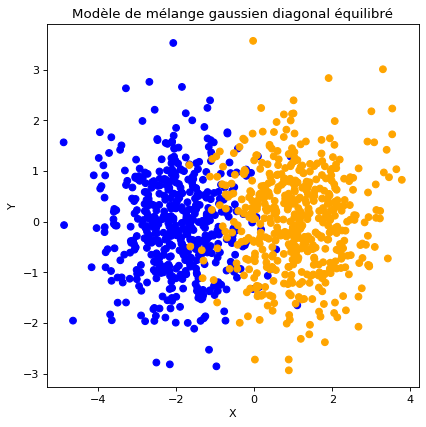

In [20]:
n = 1000
pi_1 = 0.5

sigma_1 = np.eye(2)
sigma_2 = np.eye(2)
Sigma = [sigma_1, sigma_2]

mu_1 = np.array([-2,0]).T
mu_2 = np.array([1.1,0]).T
Mu = [mu_1, mu_2]

dataset1 = simulation(n, pi_1, Sigma, Mu)
plot_simulation(dataset1, "Modèle de mélange gaussien diagonal équilibré")

On peut ensuite voir ce que donne un modèle non équilibré, en prenant par exemple pi_1 = 0.85, tout en conservant les mêmes moyennes et écart-types.

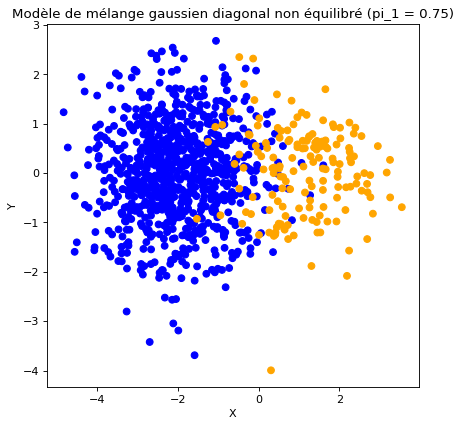

In [22]:
n = 1000
pi_1 = 0.85

sigma_1 = np.eye(2)
sigma_2 = np.eye(2)
Sigma = [sigma_1, sigma_2]

mu_1 = np.array([-2,0]).T
mu_2 = np.array([1.1,0]).T
Mu = [mu_1, mu_2]

datasetb = simulation(n, pi_1, Sigma, Mu)
plot_simulation(datasetb, "Modèle de mélange gaussien diagonal non équilibré (pi_1 = 0.75)")

Enfin, on peut jouer sur les paramètres des moyennes et écart-types des gaussiennes, ce qui modifie la distribution.

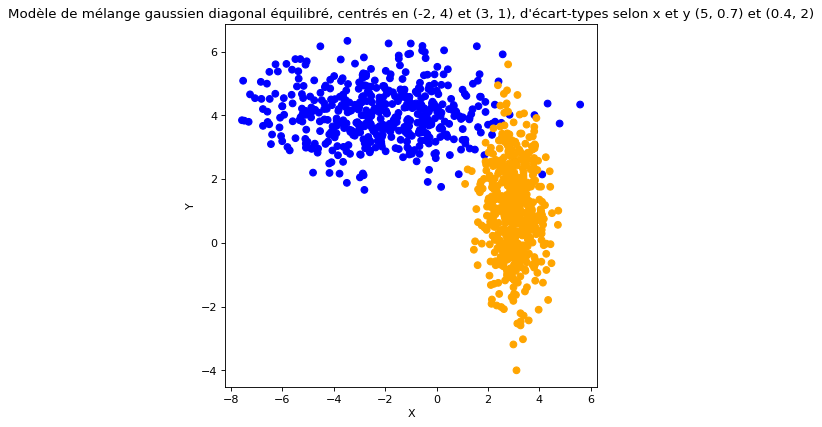

In [25]:
n = 1000
pi_1 = 0.5

sigma_1 = np.array([[5, 0], [0, 0.7]])
sigma_2 = np.array([[0.4, 0], [0, 2]])
Sigma = [sigma_1, sigma_2]

mu_1 = np.array([-2,4]).T
mu_2 = np.array([3,1]).T
Mu = [mu_1, mu_2]

datasetc = simulation(n, pi_1, Sigma, Mu)
plot_simulation(datasetc, "Modèle de mélange gaussien diagonal équilibré, centrés en (-2, 4) et (3, 1), d'écart-types selon x et y (5, 0.7) et (0.4, 2)")

# 3. Programmation de l'algorithme des kmeans et améliorations

### Question 2 : 

Nous allons ici programmer l'algorithme des kmeans, qui permet de classifier des données non supervisées. Pour commencer, l'initialisation est effectuée de manière aléatoire, c'est-à-dire en prenant un représentant aléatoire par classe.

La fonction fera appel aux fonctions :


*   euclidean(point, mean), qui renvoie la distance entre les deux points,
*   new_means, qui calcule à chaque étape le point moyen de la classe



In [26]:
def euclidean(point, mean):
    return np.sqrt((point[0]-mean[0])**2 + (point[1]-mean[1])**2)

def new_means(x, y, classes, k):
    means = []
    for i in range(k):
        xi_mean_tot = 0
        yi_mean_tot = 0
        n_i = 0
        for j in range(len(y)):
            if classes[j] == i:
                n_i += 1
                xi_mean_tot += x[j]
                yi_mean_tot += y[j]
        means.append([xi_mean_tot/n_i, yi_mean_tot/n_i])
    return means

In [43]:
def kmeans(dataset,k):
  
  x = dataset[0]
  y = dataset[1]

  has_changed = True
  
  #initialisation means
  means_num = np.random.randint(len(x), size=k)
  means = [[x[mean_num], y[mean_num]] for mean_num in means_num]

  classes = [np.argmin([euclidean(mean, (x[i], y[i])) for mean in means]) for i in range(len(y))]
  
  while has_changed :
    means = new_means(x, y, classes, k)
    new_classes = [np.argmin([euclidean(mean, (x[i], y[i])) for mean in means]) for i in range(len(y))]

    if new_classes == classes:
            has_changed = False
    else:
      classes = new_classes
    
    return classes, means

Nous implémentons de plus la fonction show_kmeans(dataset, k), qui permet de visualiser le résultat de l'algorithme du kmeans, en montrant les k classes obtenues, et en affichant les centres finaux des classes.

In [45]:
#dataset1 est défini à la question 1 avec les exemples

def show_kmeans(dataset, k, titre):

  classes, means = kmeans(dataset,k)
 
  fig = plt.figure(figsize=(6, 6), dpi=80)
  ax = fig.add_subplot(111)
  ax.scatter(dataset[0], dataset[1], c = classes)
  for i in range (k):
    ax.scatter(means[i][0], means[i][1])
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  plt.title("Application du kNN au "+titre)
  plt.show()

k = 2

Réalisons un premier test pour voir le fonctionnement sur le dataset1.

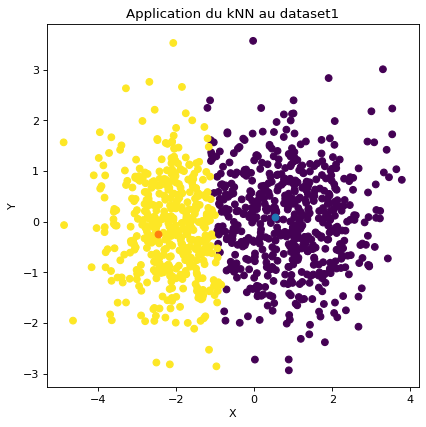

In [46]:
show_kmeans(dataset1, k, "dataset1")

L'algorithme semble bien fonctionner. Nous retrouvons globalement nos deux classes. La suite de cette étude va chercher à améliorer ces performances.

### Question 3 : 

Créons ces trois dataset :


Le dataset1 a déjà été construit à la question 1. Le voici :

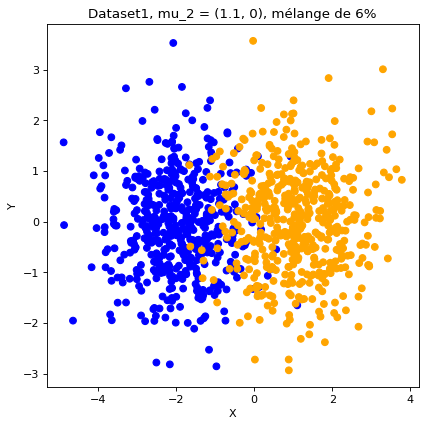

In [34]:
plot_simulation(dataset1, "Dataset1, mu_2 = (1.1, 0), mélange de 6%")

Définissons maintenant le dataset2, avec cette fois-ci  mu2 = (0,0)

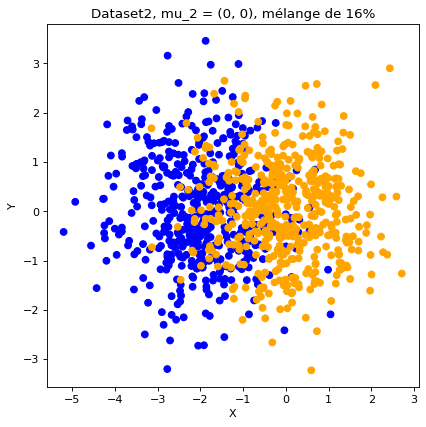

In [36]:
sigma_1 = np.eye(2)
sigma_2 = np.eye(2)
Sigma = [sigma_1, sigma_2]

mu_1 = np.array([-2,0]).T
mu_2 = np.array([0,0]).T
Mu = [mu_1, mu_2]

dataset2 = simulation(n, pi_1, Sigma, Mu)
plot_simulation(dataset2, "Dataset2, mu_2 = (0, 0), mélange de 16%")

Pour finir, voilà le dataset3, avec mu3 = (-0.6, 0)

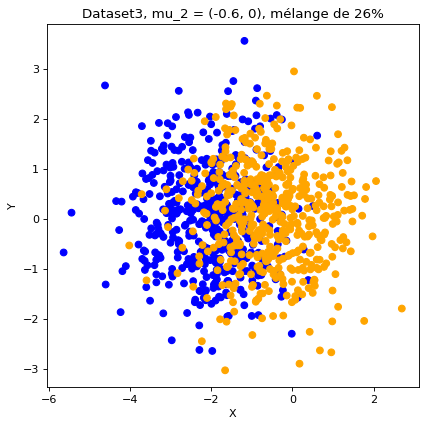

In [37]:
sigma_1 = np.eye(2)
sigma_2 = np.eye(2)
Sigma = [sigma_1, sigma_2]

mu_1 = np.array([-2,0]).T
mu_2 = np.array([-0.6,0]).T
Mu = [mu_1, mu_2]

dataset3 = simulation(n, pi_1, Sigma, Mu)
plot_simulation(dataset3, "Dataset3, mu_2 = (-0.6, 0), mélange de 26%")

Nous constatons comme nous pouvions nous y attendre que plus les moyennes définssant les deux gaussiennes sont proches, plus les gaussiennes sont mélangées. Il semble donc être de plus en plus dur de pouvoir séparer les deux classes à l'aide d'un algorithme, en particulier des kmeans.

### Question 4 :
Regardons justement ce que donne l'algorithme des kmeans sur le dataset1 pour juger de son efficacité. Nous allons le lancer plusieurs fois, afin de constater l'influence de l'initialisation.

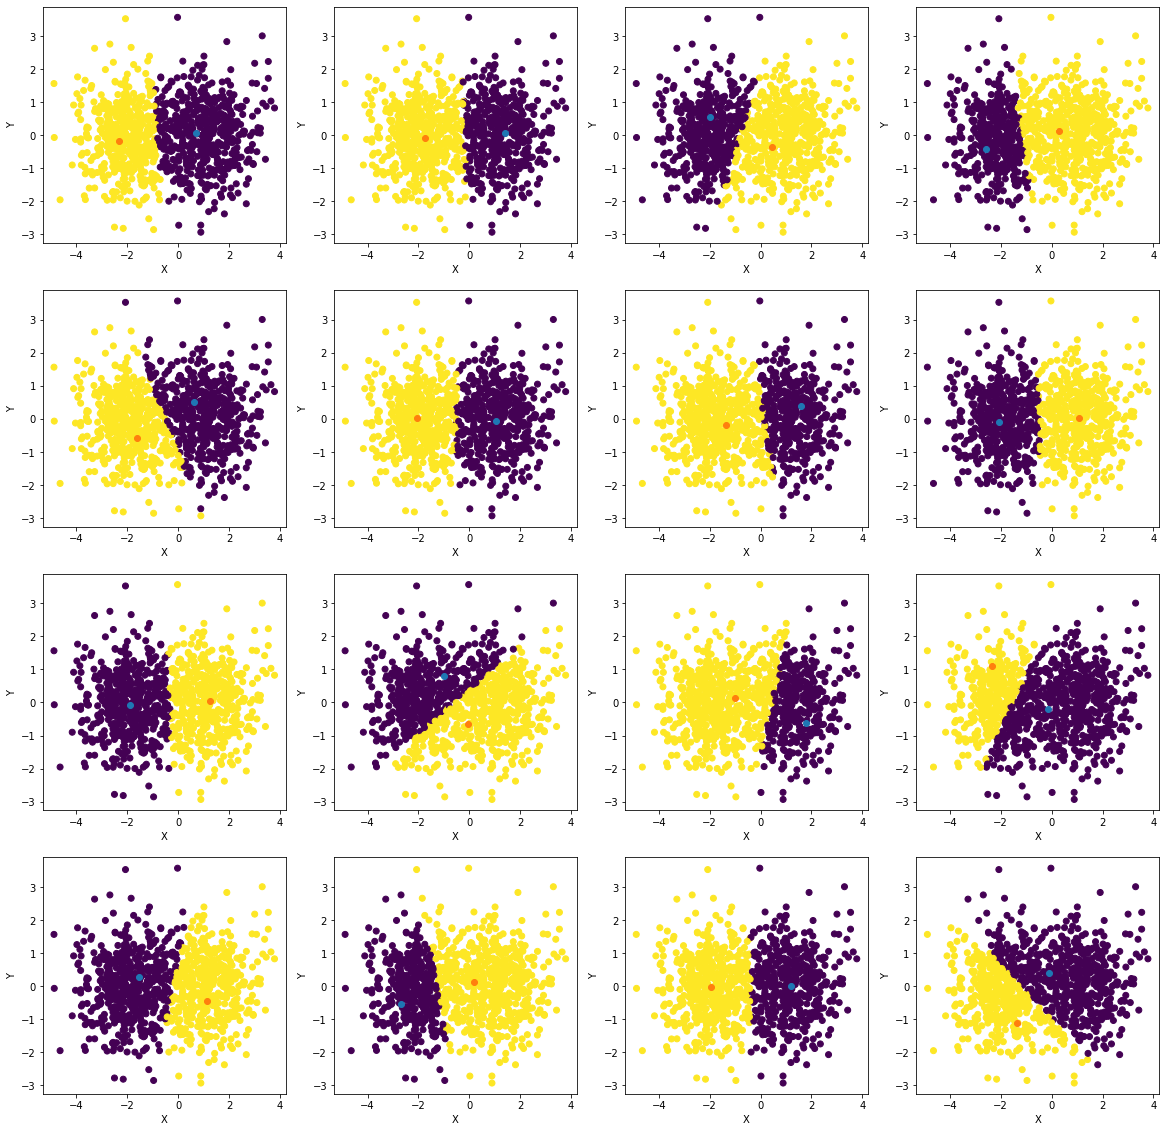

In [38]:
fig, ax = plt.subplots(4,4, figsize=(20,20))
for i in range(4):
    for j in range(4):
        classes, means = kmeans(dataset1,k)
        ax[i][j].scatter(dataset1[0], dataset1[1], c = classes)
        for t in range (k):
          ax[i][j].scatter(means[t][0], means[t][1])
        ax[i][j].set_xlabel('X')
        ax[i][j].set_ylabel('Y')

Nous constatons des résultats variables. Les deux classes sont souvent assez bien déterminées par l'algorithme des kmeans, mais parfois le résultat n'est pas parfait. Nous allons donc optimiser l'initialisation afin d'éviter ce genre de situation.

Nous allons donc définir une nouvelle initialisation. Pour cela, le premier point sera pris au hasard, et le second de façon à privilégier les points éloignés. Ainsi, la probabilité d'un point d'être choisi sera proportionnelle à la distance avec le premier point.

In [39]:
def init(dataset, k):
    x, y = dataset[0], dataset[1]
    mean1_ind = np.random.randint(len(x), size=1)[0]
    means = [[x[mean1_ind], y[mean1_ind]]]
    count = k-1
    y2 = y.copy()
    x2 = x.copy()
    last_index = mean1_ind
    while count>0:
        # on s'assure de supprimer le premier mean
        y2 = np.delete(y2, last_index)
        x2 = np.delete(x2, last_index)
        #on calcule les distances entre ce mean et tous les points
        distances = np.array([min([euclidean(mean, (x2[i], y2[i])) for mean in means])for i in range(len(x2))])
        #on transforme en proba d'être choisi
        probas = distances*distances/sum(distances*distances)
        #on tire au hasard l'indice du prochain mean choisi
        last_index = np.random.choice(len(y2), 1, p=probas)[0]
        means.append([x2[last_index], y2[last_index]])
        count -= 1
    return means

On définit le nouvel algorithme des kmeans :

In [41]:
def new_kmeans(dataset,k):
  
  x = dataset[0]
  y = dataset[1]

  has_changed = True
  
  #initialisation means
  means = init(dataset, k)

  classes = [np.argmin([euclidean(mean, (x[i], y[i])) for mean in means]) for i in range(len(y))]
  
  while has_changed :
    means = new_means(x, y, classes, k)
    new_classes = [np.argmin([euclidean(mean, (x[i], y[i])) for mean in means]) for i in range(len(y))]

    if new_classes == classes:
            has_changed = False
    else:
      classes = new_classes
    
    return classes, means

Regardons ce que donne cette algorithme sur le dataset1 :

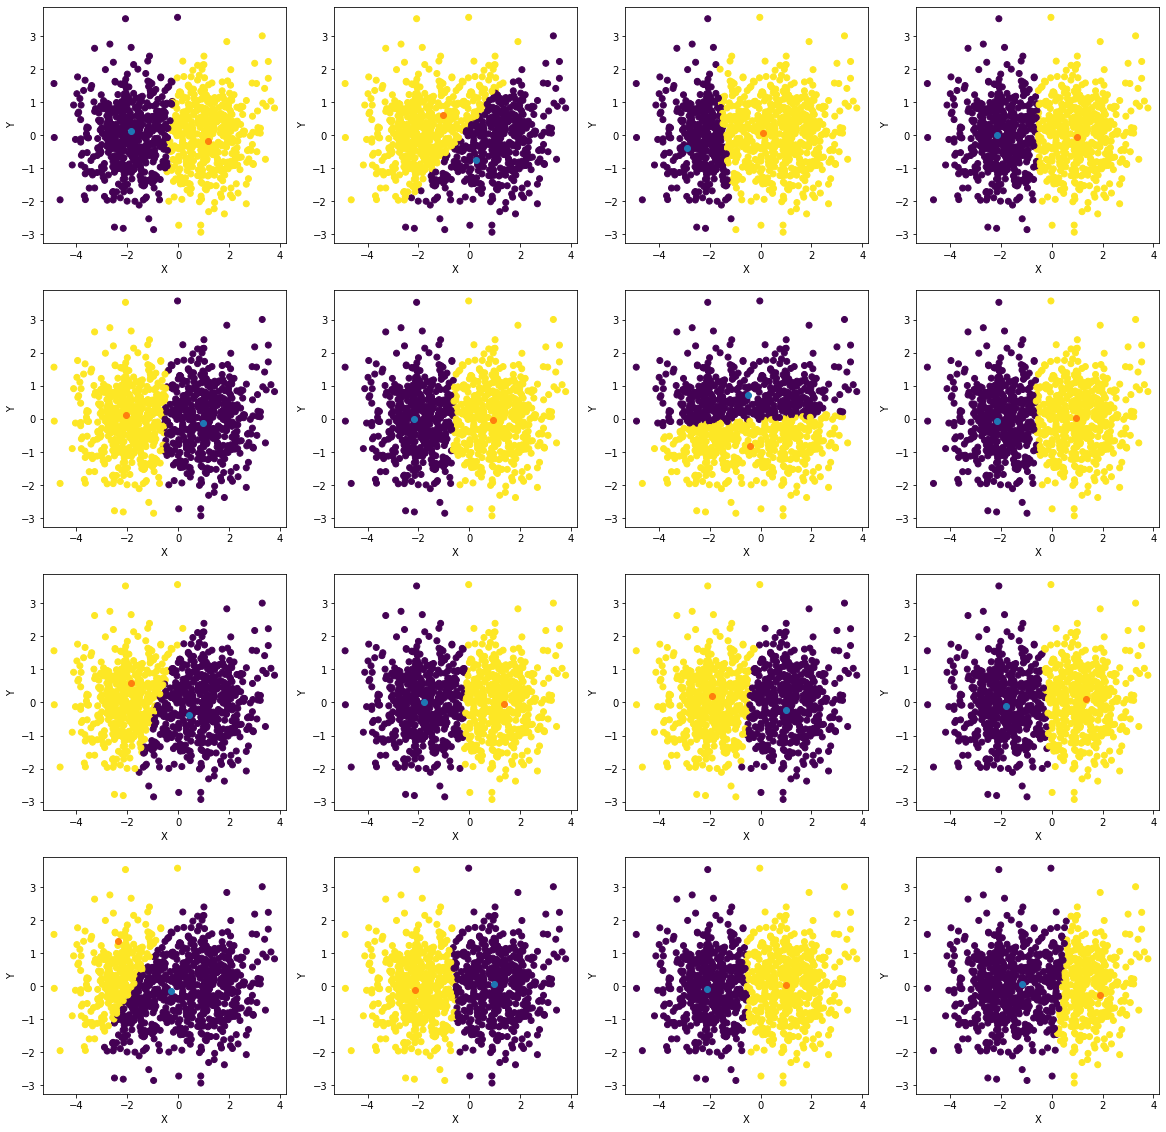

In [44]:
fig, ax = plt.subplots(4,4, figsize=(20,20))
for i in range(4):
    for j in range(4):
        classes, means = new_kmeans(dataset1,k)
        ax[i][j].scatter(dataset1[0], dataset1[1], c = classes)
        for t in range (k):
          ax[i][j].scatter(means[t][0], means[t][1])
        ax[i][j].set_xlabel('X')
        ax[i][j].set_ylabel('Y')

On constate une amélioration des résultats dans la majorité des cas. Il y a cependant quelques cas qui ne sont pas très bons, et nous verrons dans la denrière partie si l'algorithme CEM permet d'obtenir de meilleures résultats.

### Question 5 :
Mettons en place cette algorithme des kmeans maintenant que nous le trouvons satisfaisant.

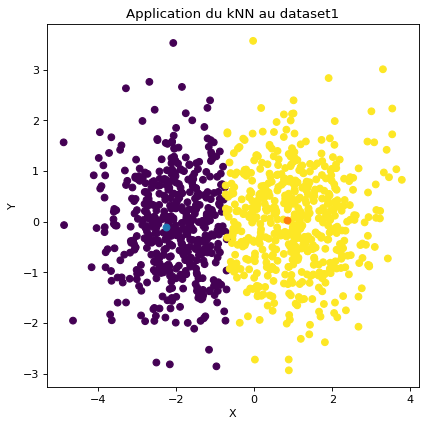

In [48]:
class_point, means = new_kmeans(dataset1,k)
show_kmeans(dataset1, k, "dataset1")

Sur le dataset 2 :

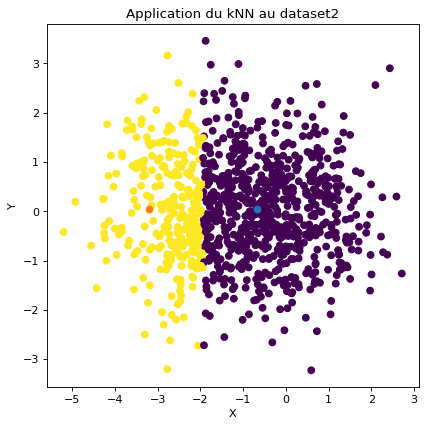

In [53]:
class_point, means = new_kmeans(dataset2, k)
show_kmeans(dataset2, k, "dataset2")

Sur le dataset 3 :

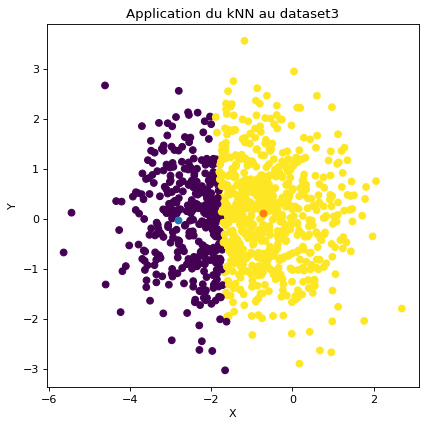

In [54]:
class_point, means = new_kmeans(dataset3,k)
show_kmeans(dataset3, k, "dataset3")

Les résultats sont plutôt correctes. Cependant, nous voyons que l'algorithme des kmeans est incapable de retrouver qu'il y a deux classes, et donc de les séparer plus précisémment. De plus, nous constatons toujours une grande dépendance à l'initialisation.

# 4. Mise en place de l'algorithme CEM



### Question 6 : 
Implémentons désormais l'algorithme CEM pour voir si les performances obtenues sont meilleures.

In [93]:
def CEM(dataset, k=2, colors = ('r', 'b')):
  x, y = dataset[0], dataset[1]
  x = np.c_[x,y]

  # Initialisation
  pi_1 = 0.5
  mu_1 = np.random.uniform(0, 1, 2)
  mu_2 = np.random.uniform(0, 1, 2)
  theta = [pi_1, 1-pi_1, mu_1, mu_2]

  # Initialisation
  has_converged = False
  theta = np.array(theta)

  # Iterations
  while not has_converged:
    # Etape E
    t = []
    sum = 0
    for i in range(k):
      X_i_k = theta[i] * sc.multivariate_normal.pdf(x, mean = theta[k + i])
      t.append(X_i_k)
      sum = sum + X_i_k
    t = np.array([x/sum for x in t])

    #Etape C
    z_1 = []
    z_2 = []

    for i in range(np.shape(t)[1]):
      if t[0][i] > t[1][i]:
        z_1.append(x[i])
      else:
        z_2.append(x[i])
    z_1 = np.array(z_1)
    z_2 = np.array(z_2)

    # Etape M
    mu_new = []
    mu_new.append((np.sum(z_1[:,0]) / np.shape(z_1)[0], np.sum(z_1[:,1]) / np.shape(z_1)[0]))
    mu_new.append((np.sum(z_2[:,0]) / np.shape(z_2)[0], np.sum(z_2[:,1]) / np.shape(z_2)[0]))
    mu_new = np.array(mu_new)
    has_converged = not ((mu_new[0,0] != theta[2][0]) | (mu_new[0,1] != theta[2][1]) | (mu_new[1,0] != theta[3][0]) | (mu_new[1,1] != theta[3][1]))
    theta[2] = mu_new[0]
    theta[3] = mu_new[1]
  
  #x = z_1[:,0].copy()
  x = np.concatenate((z_1[:,0], z_2[:,0]))
  #y = z_1[:,1].copy()
  y = np.concatenate((z_1[:,1], z_2[:,1]))
  c = [colors[0] if i<z_1.shape[0] else colors[1] for i in range(len(x))]
  mean = mu_new
  
  return x, y, c, mean

Affichons de nombreuses visualisations pour le dataset1, afin de voir si les performances obtenues sont meilleures :

<ipython-input-93-2c115b51025e>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  theta = np.array(theta)


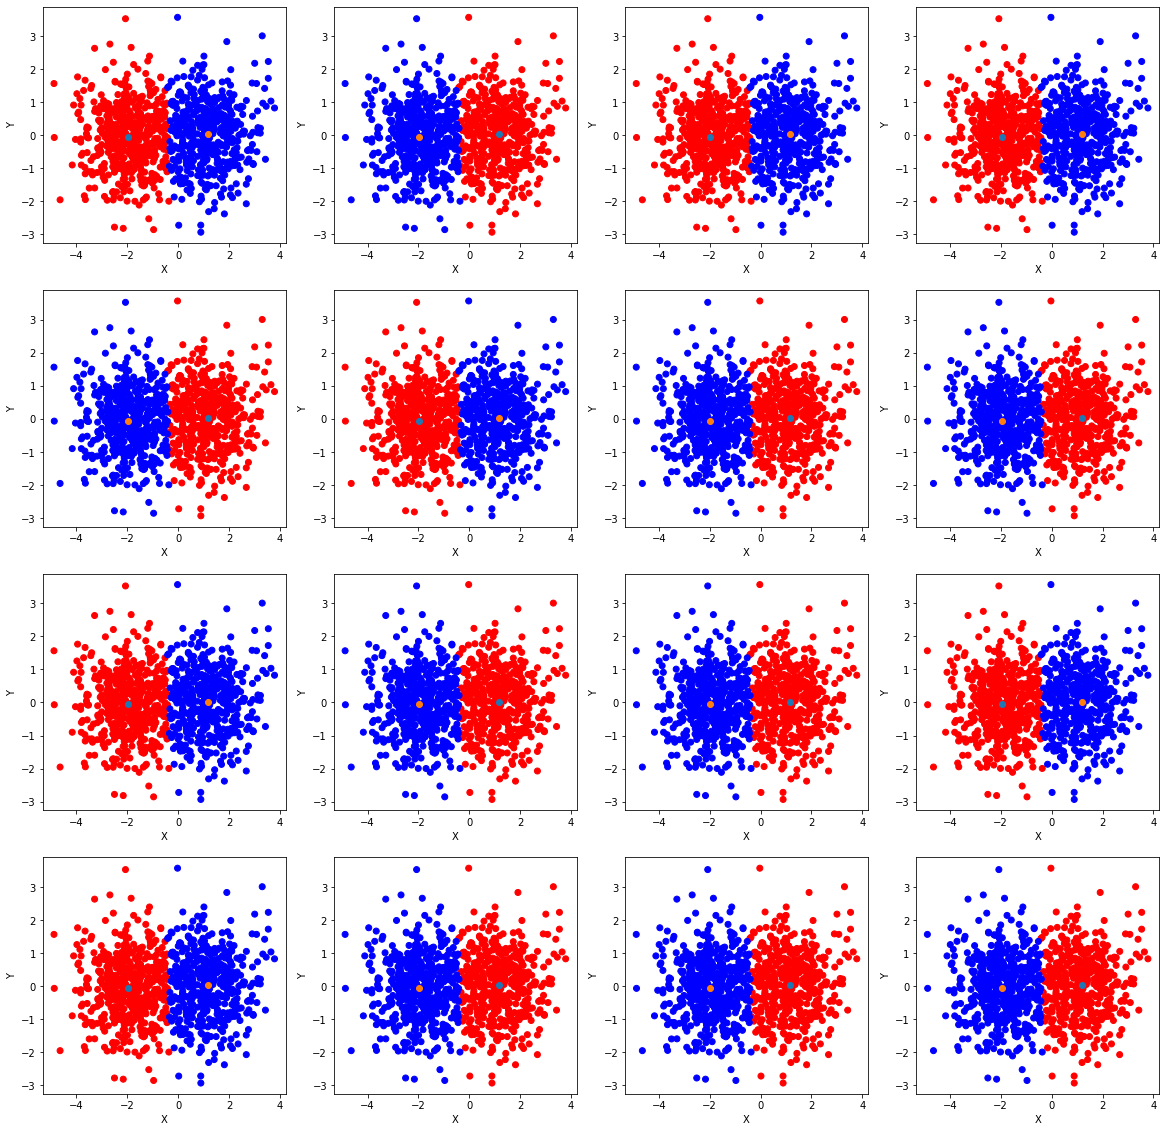

In [94]:
fig, ax = plt.subplots(4,4, figsize=(20,20))
for i in range(4):
    for j in range(4):
        res = CEM(dataset1)
        means = res[3]

        ax[i][j].scatter(res[0], res[1], c = res[2])
        for t in range (k):
          ax[i][j].scatter(means[t][0], means[t][1])
        ax[i][j].set_xlabel('X')
        ax[i][j].set_ylabel('Y')

On constate désormais que nous n'avons plus de problèmes d'initialisation due à la partie aléatoire du kmeans. Toutes les outputs sont identiques, et extrêmement bonnes.

Nous pouvons donc appliquer également cette méthode aux dataset2 et dataset3 :

<ipython-input-93-2c115b51025e>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  theta = np.array(theta)


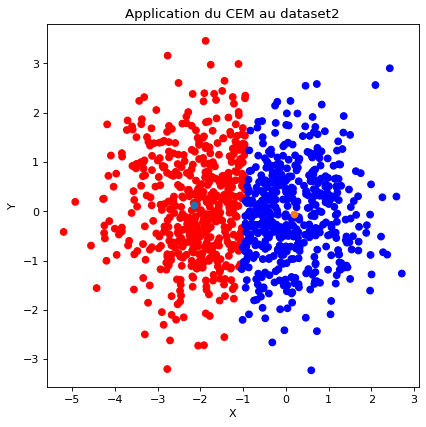

In [95]:
res = CEM(dataset2)
means = res[3]
 
fig = plt.figure(figsize=(6, 6), dpi=80)
ax = fig.add_subplot(111)
ax.scatter(res[0], res[1], c = res[2])
for i in range (k):
  ax.scatter(means[i][0], means[i][1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.title("Application du CEM au dataset2")
plt.show()

<ipython-input-93-2c115b51025e>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  theta = np.array(theta)


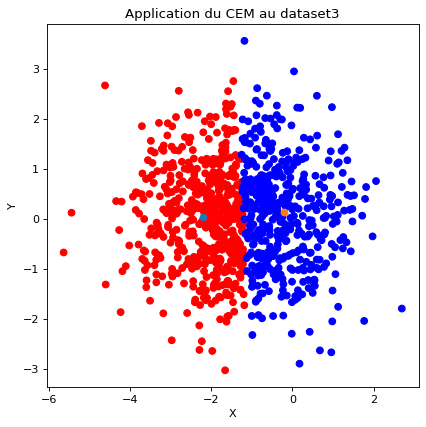

In [97]:
res = CEM(dataset3)
means = res[3]
 
fig = plt.figure(figsize=(6, 6), dpi=80)
ax = fig.add_subplot(111)
ax.scatter(res[0], res[1], c = res[2])
for i in range (k):
  ax.scatter(means[i][0], means[i][1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.title("Application du CEM au dataset3")
plt.show()

# 5. Conclusion 

Nous avons mis en place dans ce BE l'algorithme des kmeans. Nous avons pu constater que les kmeans étaient très dépendants de l'initialisation, et donc que l'output pouvait varier beaucoup d'une classificaiton à l'autre.  
L'algorithme CEM a lui beaucoup moins de variabilité, et permet de retrouver plus précisémment les deux classes. Il semble plus pertiennt de l'utiliser pour ce genre de classification non supervisée.